<a href="https://colab.research.google.com/github/meucham11/Dacon/blob/master/Dacon_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dacon.io/codeshare/1047?dtype=recent

데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다.

-     센서는 온도를 측정하였습니다.

-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다.

-     예측 대상(target variable)은 Y18입니다.



train.csv 

-     30일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y00~Y17)

-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)



test.csv 

-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)



sample_submission.csv

-     제출 양식 예시

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
# My Drive 밑에 저장했다면 그대로 두시면 됩니다.
folder = "Dacon/02_temp_pred/AIFrenz_Season1_dataset"
project_dir = ""

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/Dacon/02_temp_pred/AIFrenz_Season1_dataset


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals


from IPython.display import clear_output

import os
import time
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import pandas as pd

# Machine Learning Algorithms
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

# DATA

In [ ]:
train= pd.read_csv('./train.csv',index_col='id')
test = pd.read_csv('./test.csv',index_col='id')
submission = pd.read_csv('./sample_submission.csv')

train = train.astype(np.float32)
test = test.astype(np.float32)
submission = submission.astype(np.float32)

In [ ]:
indicator_dict = {
    'temperature'   : ["X00","X07","X28","X31","X32"], #기온
    'localpressure' : ["X01","X06","X22","X27","X29"], #현지기압
    'windspeed'     : ["X02","X03","X18","X24","X26"], #풍속
    'precipitation' : ["X04","X10","X21","X36","X39"], #일일 누적강수량
    'atmpressure'   : ["X05","X08","X09","X23","X33"], #해면기압
    'insolation'    : ["X11","X34","X14","X16","X19"], #일일 누적일사량
    'humidity'      : ["X12","X20","X30","X37","X38"], #습도
    'winddirection' : ["X13","X15","X17","X25","X35"], #풍향
}


In [ ]:
idx1 = train[train['Y18'].isnull()].index
idx2 = train[~train['Y18'].isnull()].index

train1_X = train[train.columns[:40]].loc[idx1].copy()
train1_Ys = train[train.columns[40:-1]].loc[idx1].copy()

train2_X = train[train.columns[:40]].loc[idx2].copy()
train2_Y18 = train[train.columns[-1]].loc[idx2].copy()

test_X = test.copy()

combined_X = pd.concat([train1_X, train2_X, test_X], axis=0)
X_list = [train1_X, train2_X, test_X]

# 전처리

## 결측치

In [ ]:
print(combined_X.isnull().sum().sum())
print(train1_Ys.isnull().sum().sum())
print(train2_Y18.isnull().sum())

0
0
0


# 이상치

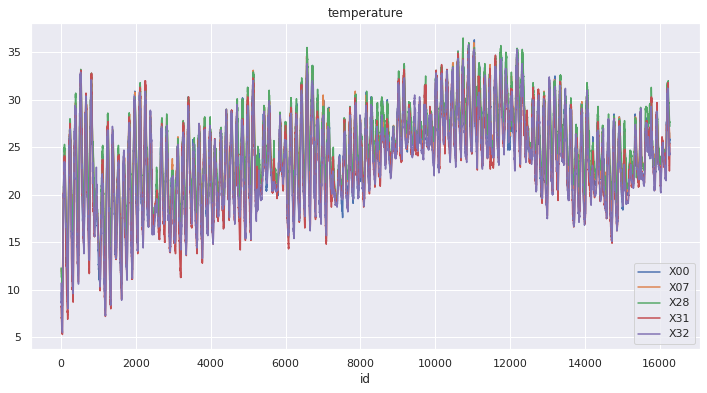

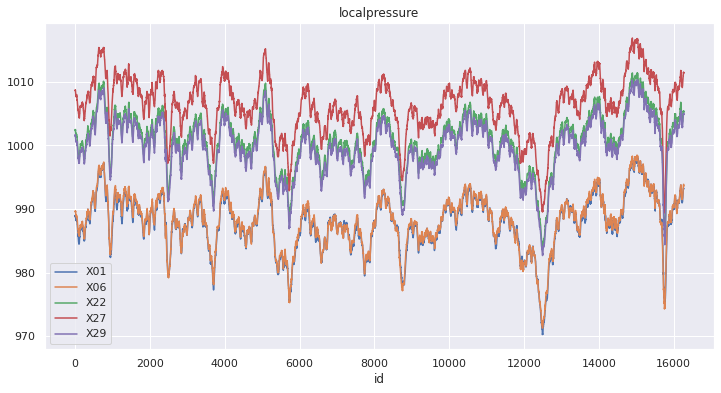

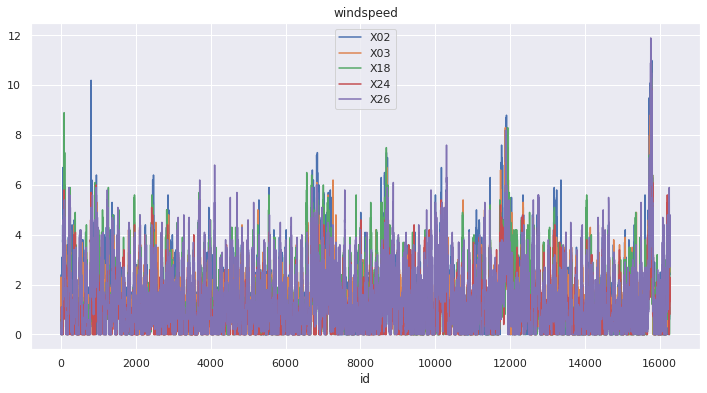

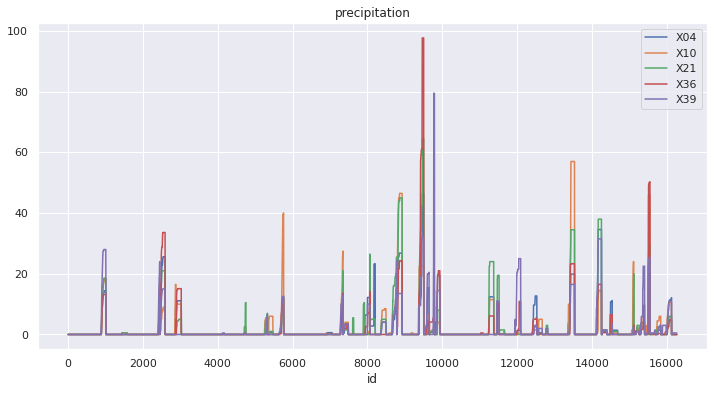

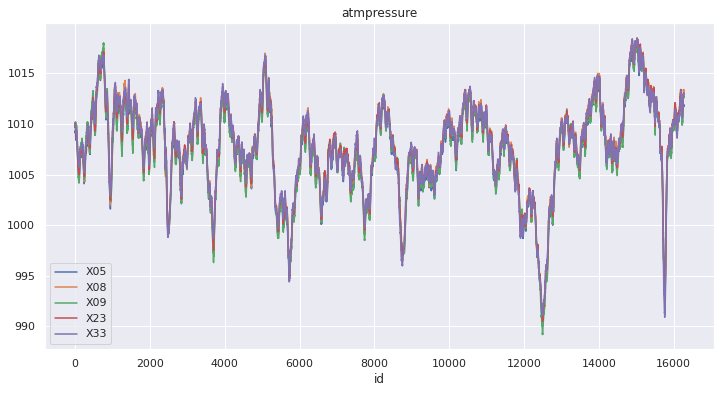

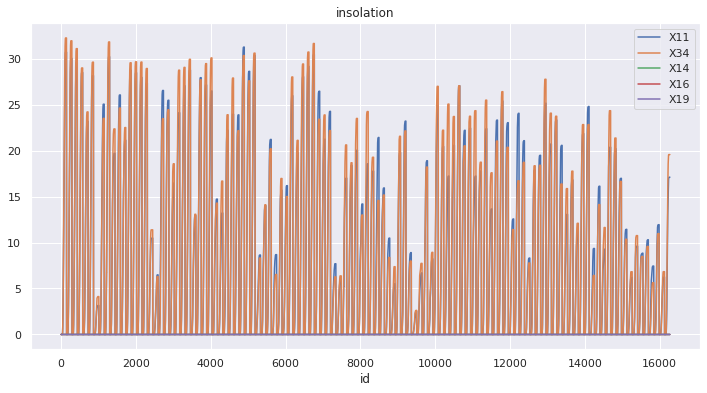

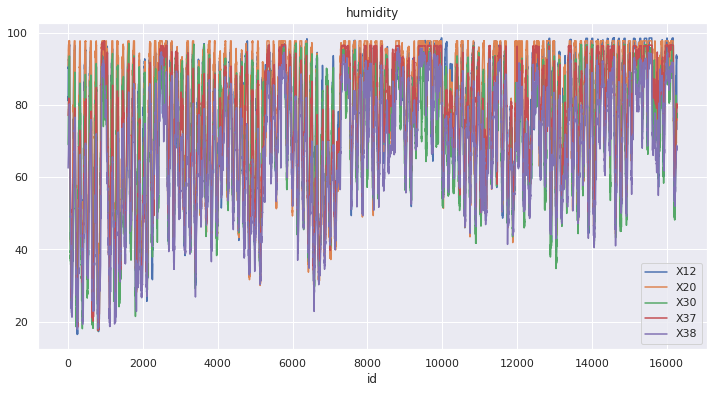

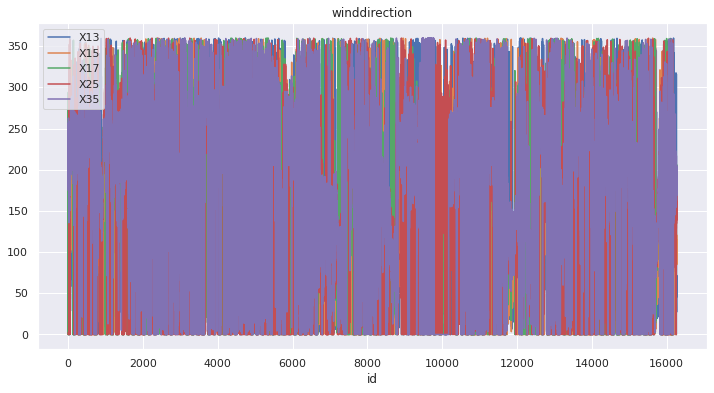

In [ ]:
for k, v in indicator_dict.items():
    combined_X.reset_index().plot(x='id', y=v, figsize=(12, 6))
    plt.gca().set_title(k)

In [ ]:
# Insolation 에서 X14, X16, X19 는 관측지가 없음. => Drop!
for X in X_list + [combined_X]:
    X.drop(['X14', 'X16', 'X19'], axis=1, inplace=True)
    
indicator_dict['insolation'] = ["X11","X34"]

In [ ]:
for X in X_list + [combined_X]:
    X['date'] = X.index // 144
    X['time'] = X.index % 144

In [ ]:
for X in X_list:
    dates = X['date'].unique()
    for d in dates:
        day_idx = X.loc[X['date'] == d].index
        for f in indicator_dict['insolation']:
            X.loc[day_idx, f] = X.loc[day_idx, f] - X.loc[day_idx, f].shift(periods=6).fillna(0)

In [ ]:
for X in X_list:
    dates = X['date'].unique()
    for f in indicator_dict['precipitation']:
        for d in dates[::-1]:
            day_idx = combined_X.loc[combined_X['date'] == d].index
            yes_day_idx = combined_X.loc[(combined_X['date'] == d-1)].index
            day_precip = combined_X.loc[(yes_day_idx | day_idx), f]
            
            # 편의를 위해 Train1, Train2, Test set 각각의 첫날(d=0)의 하루 전 누적 강수량은 0으로 고정함.
            yesterday_cum_precip = day_precip.loc[yes_day_idx].max() if d != 0 else 0 
            day_precip.loc[day_idx] += yesterday_cum_precip
            day_precip_shift = day_precip.shift(periods=36).fillna(0)
            
            X.loc[day_idx, f] = day_precip.loc[day_idx] - day_precip_shift.loc[day_idx]

# 탐색적 자료분석

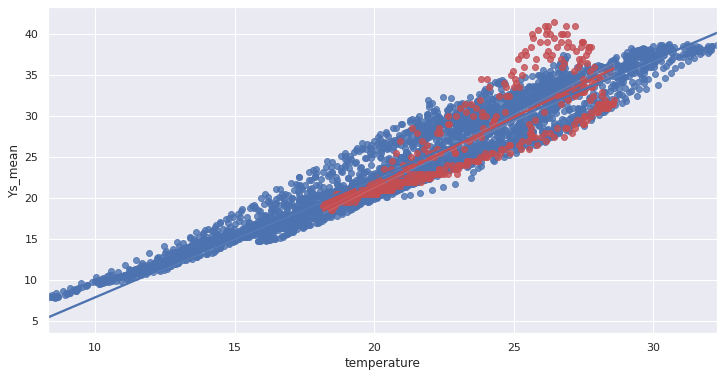

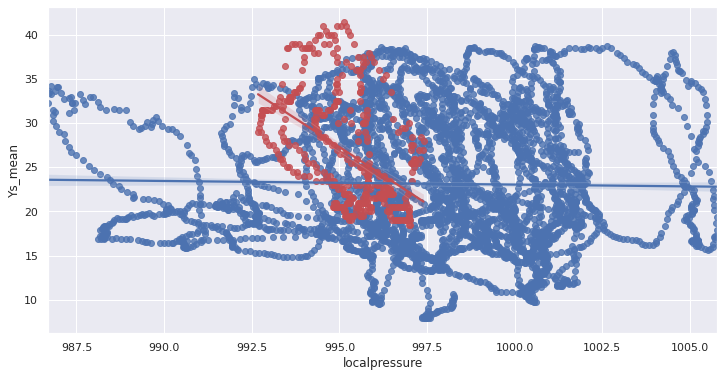

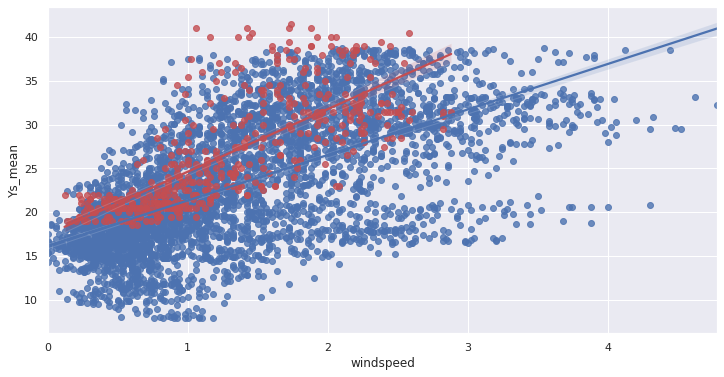

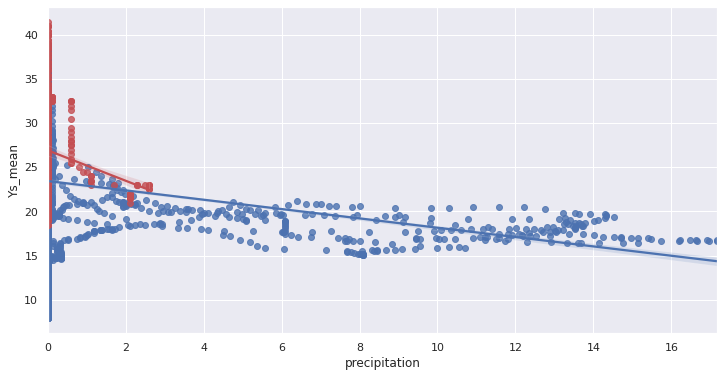

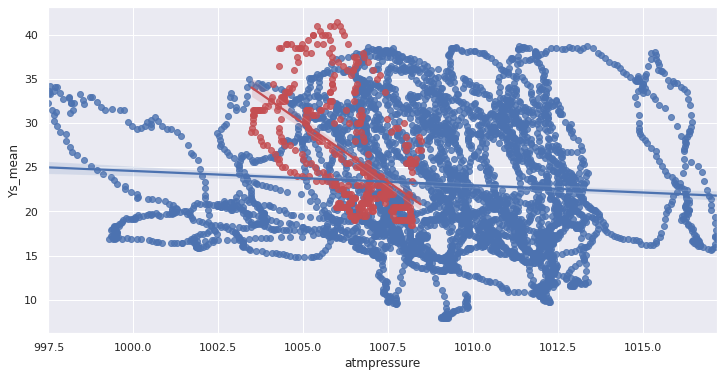

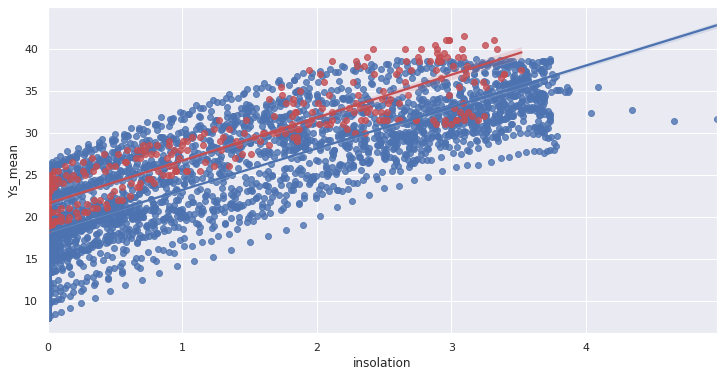

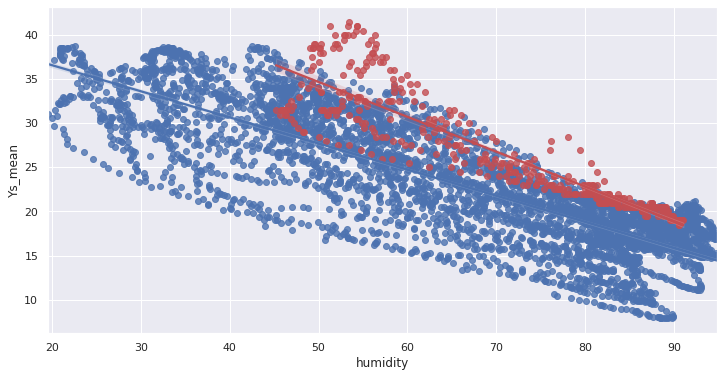

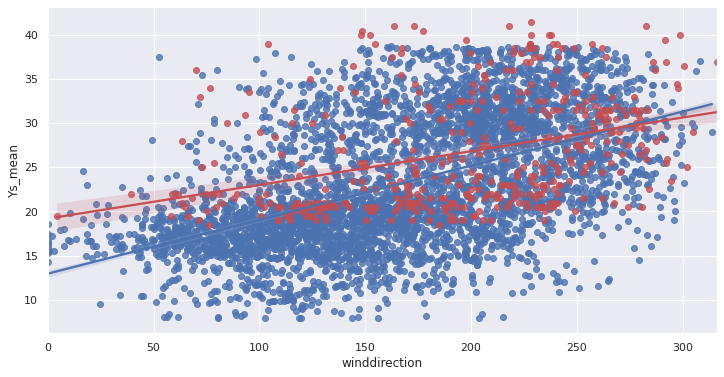

In [ ]:
train1_Ys_mean = train1_Ys.mean(axis=1)
for k, v  in indicator_dict.items():
    train1_feature_mean = train1_X[v].mean(axis=1)
    train2_feature_mean = train2_X[v].mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.regplot(train1_feature_mean, train1_Ys_mean, ax=ax)
    sns.regplot(train2_feature_mean, train2_Y18, ax=ax, color='r')
    ax.set_xlabel(k)
    ax.set_ylabel('Ys_mean')

In [ ]:
# Training data가 부족하다는 Task의 특성상 Linear model이 적절하다고 판단함. 
# 따라서 Train1과 Train2에서 consistent하게 linear한 상관관계가 있는 temperature, humidity, insolation 외에는 모두 drop 하기로 함.

for df in X_list:
    df.drop(indicator_dict['localpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['atmpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['windspeed'], axis=1, inplace=True)
    df.drop(indicator_dict['winddirection'], axis=1, inplace=True)
    df.drop(indicator_dict['precipitation'], axis=1, inplace=True)
indicator_dict = dict((k,indicator_dict[k]) for k in ['temperature', 'humidity', 'insolation'] if k in indicator_dict)